In [2]:
%pip install -U tavily-python langchain_community
%pip install 'numpy<2.0'

Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl (20.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': "Beginner's Guide to LangGraph: Understanding State, Nodes, and ...",
  'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sh

In [12]:
%pip install openai langchain-openai

  Using cached langchain_openai-0.3.7-py3-none-any.whl.metadata (2.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached langchain_openai-0.3.7-py3-none-any.whl (55 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [18]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI()
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [15]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

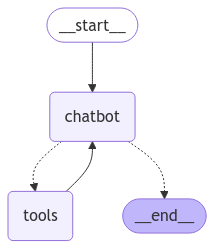

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"title": "\uc778\uad6c\ubcc0\ud654\uc640 \uc778\uad6c\uc131\uc7a5\ub960 | \uc11c\uc6b8\uc5f0\uad6c\ub370\uc774\ud130\uc11c\ube44\uc2a4", "url": "https://data.si.re.kr/data/%ED%86%B5%EA%B3%84%EB%A1%9C-%EB%B3%B8-%EC%84%9C%EC%9A%B8-%EC%9D%B8%EA%B5%AC%ED%8E%B8/267", "content": "\uc11c\uc6b8\uc2dc \uc790\uce58\uad6c\ubcc4 \uc778\uad6c\uc218\ub294 \uc791\uac8c\ub294 11\ub9cc \uba85\uc5d0\uc11c \ub9ce\uac8c\ub294 64\ub9cc \uba85\uc5d0 \ub2ec\ud55c\ub2e4. \uac01 \uad6c\ubcc4 \uc778\uad6c\ub97c \ud3c9\uade0\uc801\uc73c\ub85c \uacc4\uc0b0\ud558\uba74 \uc57d 40\ub9cc \uba85\uc5d0 \uc721\ubc15\ud55c\ub2e4. \uc774 \uc815\ub3c4\uc758 \uc778\uad6c\uaddc\ubaa8\ub97c \uac00\uc9c4 \uad6c\ub294", "score": 0.87706697}, {"title": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc/\uc778\uad6c - \ub098\ubb34\uc704\ud0a4", "url": "https://namu.wiki/w/%EC%84%9C%EC%9A%B8%ED%8A%B9%EB%B3%84%EC%8B%9C/%EC%9D%B8%EA%B5%AC", "content": "\uc11c\uc6b8\ud2b9\ubcc4\uc2dc\uc758 \uc778\uad6c\uc5d0 \ub300\ud55c \ubb38